<a href="https://colab.research.google.com/github/rakeshsiri/AI_at_scale/blob/master/Distillation_HelloWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Tue Jan 14 16:58:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install transformers pytorch-nlp

     |████████████████████████████████| 450kB 3.4MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 1.0MB 10.9MB/s 
     |████████████████████████████████| 870kB 19.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=00b8faf66227faf552164df94ca1b6b4932354bdd83b5d6620a2c1e518689442
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from transformers import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [0]:
train_data_full, test_data_full = imdb_dataset(train=True, test=True)

aclImdb_v1.tar.gz: 84.1MB [00:02, 37.6MB/s]                            


In [0]:
len(train_data_full),len(test_data_full)

(25000, 25000)

In [0]:
random.shuffle(train_data_full)
random.shuffle(test_data_full)
train_data = train_data_full[:]
test_data = test_data_full[:]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(25000, 25000, 25000, 25000)

In [0]:
%%time
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

len(train_tokens), len(test_tokens)

CPU times: user 3min 11s, sys: 642 ms, total: 3min 12s
Wall time: 3min 12s


In [0]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [0]:
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((25000, 512), (25000, 512))

In [0]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((25000,), (25000,), 0.5, 0.5)

In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [0]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
baseline_predicted = baseline_model.predict(test_texts)

In [0]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.90      0.89      0.90     12500
         pos       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



In [0]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks)
        linear_output = self.linear(pooled_output)
        return linear_output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

In [0]:
BATCH_SIZE = 12
EPOCHS = 2

In [0]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [0]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [0]:
loss_func = nn.BCEWithLogitsLoss().cuda()

In [0]:
from tqdm.autonotebook import tqdm

In [0]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in tqdm(enumerate(train_dataloader)):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        # clear_output(wait=True)
        # print('Epoch: ', epoch_num + 1)
        # print("{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

In [0]:
bert_clf

In [0]:
torch.save(bert_clf.state_dict(), '/content/drive/My Drive/experiments/BERT-imdb-4.pth')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

BERT-imdb.pth  data  drive  sample_data


In [0]:
!cd /content/drive

In [0]:
!ls

BERT-imdb.pth  data  drive  sample_data


In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        probas = bert_clf(token_ids, masks)
        numpy_probas = probas.cpu().detach().numpy()
        
        bert_predicted += list(sigmoid(numpy_probas[:, 0]) > 0.5)

In [0]:
print(classification_report(test_y, bert_predicted))


              precision    recall  f1-score   support

       False       0.95      0.90      0.93     12500
        True       0.91      0.96      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



Distilling BERT

In [0]:
train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
train_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        train_logits.append(numpy_logits)
train_logits = np.vstack(train_logits)

In [0]:
print(classification_report(train_y, sigmoid(train_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98     12500
        True       0.97      0.99      0.98     12500

    accuracy                           0.98     25000
   macro avg       0.98      0.98      0.98     25000
weighted avg       0.98      0.98      0.98     25000



In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts, train_logits)

In [0]:
distilled_predicted_logits = distilled_model.predict(test_texts)

In [0]:
print(classification_report(test_y, sigmoid(distilled_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       0.92      0.86      0.89     12500
        True       0.87      0.92      0.90     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



(array([10001.,  1739.,   242.,   131.,   102.,    73.,   106.,   214.,
         1099., 11293.]),
 array([-6.467285  , -5.164265  , -3.8612452 , -2.558225  , -1.2552049 ,
         0.04781508,  1.3508351 ,  2.653855  ,  3.9568753 ,  5.2598953 ,
         6.5629153 ], dtype=float32),
 <a list of 10 Patch objects>)

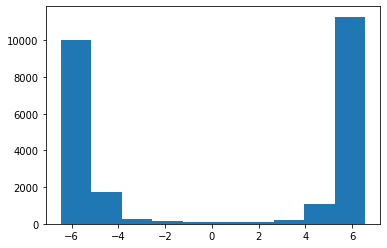

In [0]:
plt.hist(train_logits)